### Importing all required sklearn libraries

In [1]:
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil import relativedelta
import seaborn as sns

### Setting all global variables

In [2]:
location_boston = os.getcwd() + r'\archive_boston'
location_seattle = os.getcwd() + r'\archive_seattle'
sns.set_style("whitegrid")
city_dict = {'MA':'Boston','WA':'Seattle'}
month_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
fontsize_title = 10
fontsize_label = 8
fontsize_ticks = 8
fig_size = (8,3)

### Some useful functions

In [3]:
def read_file(filename,location):
    
    """
    This function reads a .csv file
  
    Parameters:
    filename (string): file that has to be read
    location (string): location of this file
  
    Returns:
    pd.DataFrame: the file contents loaded into the dataframe
  
    """
    
    return pd.read_csv(location + '\\' + filename)  


def filter_columns(df):
    """
    This function selects columns that 
    have more than a single unique value
  
    Parameters:
    dataframe (pd.DataFrame): the dataframe whose columns need to be checked
  
    Returns:
    list : the columns that are relevant
  
    """ 
    required_cols = []
    for col in df.columns:
        if df[col].nunique() ==1:
            required_cols.append(col)
    return required_cols

def check_column_nullity(df):
    """
    This function selects columns that 
    have less that 30% null values
  
    Parameters:
    dataframe (pd.DataFrame): the dataframe whose columns need to be checked
  
    Returns:
    list : the columns that are relevant
  
    """ 
    temp = df.isna().sum().reset_index()
    temp['more_than_30%_isnull'] = temp[0].apply(lambda x : False if x/df.shape[0] < 0.3 else True)
    return temp[temp['more_than_30%_isnull'] == True]['index'].unique().tolist()


def identify_columns(df, pattern):
    """
    This function selects columns have a certain
    pattern in their names
  
    Parameters:
    dataframe (pd.DataFrame): the dataframe whose columns need to be checked
    pattern (re.compile() object): The pattern that needs to be identified
    
    Returns:
    list : the columns that match the pattern
  
    """ 
    pattern_cols = []
    for col in df.columns:
        if pattern.search(str(col).lower()):
            pattern_cols.append(col)
    return pattern_cols

# Section 1:  Business Understanding

### The AirBnb dataset contains information related to a listing , the reviews and available dates associated with it. Some important features like price,property types, room types,city, neighbourhood, host characteristics and reviews scores ratings might be useful in two ways

### 1. Making recommendations to hosts on improving their and their listings popularity,lean periods and whether prices can be raised at any point
### 2. Helping renters decide which neighborhoods and hosts are suited for their needs.
### In short , happy hosts and renters will help improve AirBnb's popularity and attract more hosts and renters likewise to use its services.

## So here are a few basic questions to get us started in the right direction
### 1. Does the listing pricing vary across cities and neighbourhoods within a city ?
### 2. What kind of property types and room types have a high usage based on the number of reviews?
### 3. What kind of amenities are associated with highly reviewed and popular listings ?
### 4. How much influence do parameters like host response rate,host response time,host since and cancellation policy have on a listing's popularity and can these be used as recommendations to the hosts? 

# Section 2 : Data Understanding

## 1. Gather

## The below set of cells will be used for reading the relevant input files for the Boston and Seattle datasets . We will read the below files
### 1. listings.csv - containing information related to a listing
### 2. reviews.csv - containing information related to the reviews associated with a listing
### 3. calendar.csv - containing information about the future dates on which the listing will be available as well as the dates when it is not.
## After reading the datasets we will concatentate them on the X-axis to make a single dataset with common columns

In [4]:
listings_boston = read_file('listings.csv',location_boston)
listings_seattle = read_file('listings.csv',location_seattle)

print("Original shapes - listings - Boston & Seattle " , listings_boston.shape,listings_seattle.shape) # check the shape of both datasets

common_columns = list(set(listings_boston) & set(listings_seattle)) # select the columns common to both

listings_df = pd.concat([listings_boston[common_columns],listings_seattle[common_columns]],axis=0) # create concatendated listings dataset

Original shapes - listings - Boston & Seattle  (3585, 95) (3818, 92)


### The reviews dataset has multiple rows against a listing id depending on the number of users it was reviewed by
### We need to first group the dataset by listing_id and aggregate on the max and min review dates and the count of reviews. 
### We will end up with a dataframe having one listing per row with the associated max and min review dates and total count of reviews for that listing


In [5]:
reviews_boston = read_file('reviews.csv',location_boston)
reviews_seattle = read_file('reviews.csv',location_seattle)

print("Original shapes - reviews - Boston & Seattle " , reviews_boston.shape,reviews_seattle.shape) # check the shape of both datasets

Original shapes - reviews - Boston & Seattle  (68275, 6) (84849, 6)


In [6]:
reviews_boston.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [7]:
common_columns_reviews = list(set(reviews_boston) & set(reviews_seattle)) # select the columns common to both

print(common_columns_reviews)

reviews_df = pd.concat([reviews_boston[common_columns_reviews],reviews_seattle[common_columns_reviews]],axis=0) # create concatendated reviews dataset

reviews_df['date'] = pd.to_datetime(reviews_df['date'],errors = 'coerce') # convert the date column to datetime format for datetime related manipulations

reviews = reviews_df.groupby('listing_id').agg(max_date = ('date','max'),
                                               min_date = ('date','min'),
                                               total_review_count = ('date','count')).reset_index() # grouping by listing_id and aggregating 
                                                                                                    #by max date(review),min date(review) and count of reviews
                                                   
reviews.drop_duplicates(inplace=True) # Dropping duplicates on all columns
print("Final shapes - reviews - Boston & Seattle " , reviews.shape,reviews.listing_id.nunique()) # print shape and unique ids after dropping duplicates,both should be the same 

['reviewer_id', 'listing_id', 'id', 'date', 'comments', 'reviewer_name']
Final shapes - reviews - Boston & Seattle  (6020, 4) 6020


### The calendar dataset has multiple rows against a listing id depending on the number of dates a listing is available.
### We need to first filter out all entries that have the "available" column value as "t" or True

In [8]:
calendar_boston = read_file('calendar.csv',location_boston)
calendar_seattle = read_file('calendar.csv',location_seattle)

print("Original shapes - calendar - Boston & Seattle " , calendar_boston.shape,calendar_seattle.shape) # check the shape of both datasets

calendar_boston = calendar_boston[calendar_boston['available'] == 't']  # filter out only available dates
calendar_seattle = calendar_seattle[calendar_seattle['available'] == 't']

print("After filtering, shapes for calendar - Boston & Seattle " ,calendar_boston.shape,calendar_seattle.shape) # check the shape of both datasets after filtering
print("Max availability dates - Boston & Seattle : ",calendar_boston.date.max(),',',calendar_seattle.date.max(),
      '\n'"Min availability dates - Boston & Seattle : ",calendar_boston.date.min(),',',calendar_seattle.date.min()) # check the max and minimum dates for both datasets

common_columns_calendar = list(set(calendar_boston) & set(calendar_seattle)) # select the columns common to both

print(common_columns_calendar)

calendar_df = pd.concat([calendar_boston[common_columns_calendar],calendar_seattle[common_columns_calendar]],axis=0) # create concatendated calendar dataset
print("After concatentation shape : " ,calendar_df.shape ,calendar_df.listing_id.nunique()) 
calendar_df.drop_duplicates(inplace=True) # Dropping duplicates on all columns
print("After dropping duplicates " ,calendar_df.shape ,calendar_df.listing_id.nunique())
print("Max and Min availability dates for concatenated dataset: " ,calendar_df['date'].max(),',',calendar_df['date'].min())

Original shapes - calendar - Boston & Seattle  (1308890, 4) (1393570, 4)
After filtering, shapes for calendar - Boston & Seattle  (643037, 4) (934542, 4)
Max availability dates - Boston & Seattle :  2017-09-05 , 2017-01-02 
Min availability dates - Boston & Seattle :  2016-09-06 , 2016-01-04
['listing_id', 'available', 'date', 'price']
After concatentation shape :  (1577579, 4) 6629
After dropping duplicates  (1577499, 4) 6629
Max and Min availability dates for concatenated dataset:  2017-09-05 , 2016-01-04


## 2. Access and Explore

### 1. We need to check how many of the listings columns have null values and retain only those that have less than 30% null values because these null values cannot be imputed without more information
### 2. Some columns have a single unique value, we will remove them as well

In [9]:
### Checking nullity of listings columns
high_nullity_columns = check_column_nullity(listings_df)

### Checking columns with a constant value
constant_value_columns = filter_columns(listings_df)

print("Columns from listings that will not be considered for further analysis" , high_nullity_columns + constant_value_columns)

Columns from listings that will not be considered for further analysis ['square_feet', 'monthly_price', 'notes', 'security_deposit', 'weekly_price', 'license', 'jurisdiction_names', 'neighbourhood_group_cleansed', 'neighborhood_overview', 'transit', 'has_availability', 'requires_license', 'country_code', 'experiences_offered', 'jurisdiction_names', 'country', 'has_availability']


In [10]:
### Filtering out columns that will be used for further analysis
data_columns = list(set(listings_df.columns) - set(constant_value_columns + high_nullity_columns))
print(data_columns)

['maximum_nights', 'host_response_rate', 'availability_365', 'availability_90', 'reviews_per_month', 'scrape_id', 'market', 'calculated_host_listings_count', 'calendar_last_scraped', 'city', 'neighbourhood', 'id', 'minimum_nights', 'host_since', 'require_guest_phone_verification', 'description', 'host_picture_url', 'calendar_updated', 'space', 'review_scores_rating', 'cleaning_fee', 'host_total_listings_count', 'host_id', 'first_review', 'last_scraped', 'longitude', 'instant_bookable', 'host_acceptance_rate', 'host_is_superhost', 'picture_url', 'review_scores_location', 'number_of_reviews', 'amenities', 'smart_location', 'room_type', 'host_name', 'property_type', 'bed_type', 'accommodates', 'summary', 'bathrooms', 'xl_picture_url', 'medium_url', 'street', 'require_guest_profile_picture', 'host_about', 'cancellation_policy', 'review_scores_accuracy', 'last_review', 'host_identity_verified', 'bedrooms', 'host_response_time', 'availability_30', 'review_scores_cleanliness', 'host_listings_

In [11]:
### Let's check the nullity,shape and unique_id counts of the final datasets

pd.DataFrame([['listings',listings_df[data_columns].isna().sum().max(),listings_df[data_columns].shape[0],listings_df.id.nunique()],
             ['reviews',reviews.isna().sum().max(),reviews.shape[0],reviews.listing_id.nunique()],
             ['calendar',calendar_df.isna().sum().max(),calendar_df.shape[0],calendar_df.listing_id.nunique()]],columns = ['Dataset','Max Null Count','Shape','UniqueId_Count'])


,Dataset,Max Null Count,Shape,UniqueId_Count
0,listings,2168,7403,7403
1,reviews,0,6020,6020
2,calendar,0,1577499,6629


# Section 3 : Data Preparation

## 3. Explore & Clean

### Question 1 . "Does the listing pricing vary across cities and neighbourhoods within a city?"

#### 1. We will first check the average price for both the cities
#### 2. We will plot two lineplots that will show the rise and fall of prices for the two cities across a timeperiod
#### 3. We will create a barplot that will show the average price for the top priced neighborhoods in Boston & Seattle
#### 4. We will create two barplots for Boston and Seattle one each, which shows the average price across the top priced neighborhoods

In [12]:
listings_df['price'].head(2),calendar_df.price.head(2) # These columns need to be converted to numerical

(0    $250.00
 1     $65.00
 Name: price, dtype: object,
 365    $65.00
 366    $65.00
 Name: price, dtype: object)

In [13]:
listings_df['state'].unique() # we need to standardize and convert the states to their respective cities

array(['MA', 'WA', 'wa'], dtype=object)

In [14]:
listings = listings_df[data_columns]
listings['city_cleansed'] = listings['state'].apply(lambda x : city_dict[x.upper()]) # replace the state values with city -Boston or Seattle
listings['price'] = listings['price'].apply(lambda x : float(str(x).replace('$','').replace(',',''))) # replace $ and convert to float type
calendar_df.rename(columns = {'price':'calendar_price','date':'calendar_date'},inplace=True) # rename the price columns in the calendar dataset to calendar price 
                                                                                             # in order to distinguish from the current listings price     
calendar_df['calendar_price'] = calendar_df['calendar_price'].apply(lambda x : float(str(x).replace('$','').replace(',',''))) # replace $ and convert to float type

In [15]:
listings['price'].describe() ### The listings pricing ranges from 10$ to 4000$ and the average value is 150$

count    7403.000000
mean      150.227881
std       124.019680
min        10.000000
25%        79.000000
50%       120.000000
75%       190.000000
max      4000.000000
Name: price, dtype: float64

### Checking the distribution of the price variable

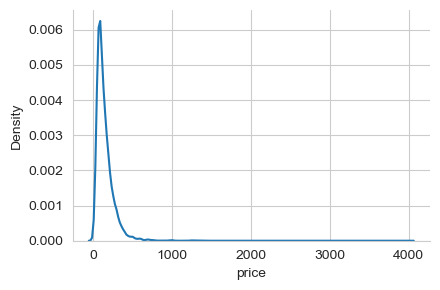

In [16]:
plot_ = sns.displot(listings['price'],height = 3,aspect=1.5,kind = 'kde') # It's a right skewed distribution with outliers

In [17]:
listings['price'].isna().sum() # There are no null values for price

0

### Merge the calendar data with the listing on listing id & Group the resulting dataframe on id,year and month and aggregate on average price

In [18]:
available_listing_price = pd.merge(calendar_df,listings[['id','state']],left_on='listing_id',right_on = 'id').drop_duplicates() # merge calendar and listings and drop duplicates
available_listing_price['calendar_date'] = pd.to_datetime(available_listing_price['calendar_date'],errors='coerce') # convert the date to datetime
available_listing_price['Month'] = available_listing_price['calendar_date'].dt.month # extract the month from the date
available_listing_price['Year'] = available_listing_price['calendar_date'].dt.year  # extract the year from the date

#The year and month will help to sort the values timeline wise

temp_x = available_listing_price.groupby(['listing_id','Year','Month']).agg(avg_price_month = ('calendar_price','mean')).reset_index() # group the data by listing_id,year and month and aggregate by average price
temp_y = pd.merge(temp_x,listings[['id','city_cleansed','neighbourhood_cleansed']],left_on = 'listing_id',right_on = 'id').drop_duplicates() # merge the grouped data with the listings to add the city and neighbourhood columns
temp_z = temp_y.groupby(['Year','Month']).agg(listing_count = ('listing_id','count'),
                                              avg_monthly_price = ('avg_price_month','mean'),
                                              city = ('city_cleansed','max')).reset_index() # Group the above data by Year,Month, aggregate on listing count,average of the average monthly price and the city

temp_z['Month'] = temp_z['Month'].apply(lambda x : month_dict[x]) # set the Month to text i.e 01 - Jan 
temp_z['Year'] = temp_z['Year'].astype(str) # convert Year to String
temp_z['Time'] = temp_z['Month'] + ' ' + temp_z['Year'] # create a new column which is the concatenated month and year for easier visualisation

### Group listings by neighbourhood and aggregate by average price

In [19]:
# group the boston listings by neighbourhood and aggregate by average price, sort values descending and select top 10
data_neighbourhood_boston = listings[listings['city_cleansed'] == 'Boston'].groupby(['neighbourhood_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(10) 

# group the seattle listings by neighbourhood and aggregate by average price, sort values descending and select top 10 
data_neighbourhood_seattle = listings[listings['city_cleansed'] == 'Seattle'].groupby(['neighbourhood_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(10)

# group the listings by neighbourhood and city and aggregate by average price, sort values descending and select top 10 
data_neighbourhood = listings.groupby(['neighbourhood_cleansed','city_cleansed']).agg(average_price = ('price','mean')).sort_values('average_price',ascending=False).reset_index().head(20)

# Collect the neighbourhood labels for plotting into lists
neighbourhood_boston = data_neighbourhood_boston.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()
neighbourhood_seattle = data_neighbourhood_seattle.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()
neighbourhood = data_neighbourhood.sort_values('average_price',ascending=False).neighbourhood_cleansed.unique().tolist()


# Section 4 : Evaluation

## Analyse

### Question 1 . "Does the listing pricing vary across cities and neighbourhoods within a city?"

###  Group the listings data by the city and aggregate on average price, listing count and max of last scraped date

In [20]:
data_city = listings.groupby('city_cleansed').agg(average_price = ('price','mean'),listing_count = ('id','count'),scraped_till_date = ('last_scraped','max')).reset_index()

## Visualize
### Question 1 . "Does the listing pricing vary across cities and neighbourhoods within a city?"

In [21]:
data_city

,city_cleansed,average_price,listing_count,scraped_till_date
0,Boston,173.925802,3585,2016-09-07
1,Seattle,127.976166,3818,2016-01-04


### We can see that Boston has a lower listing count but a higher average price even though it's been scraped till Sep 2016 as opposed to Seattle's Jan 2016

### Let's check the fluctuation in the average price per month of listings in both the cities

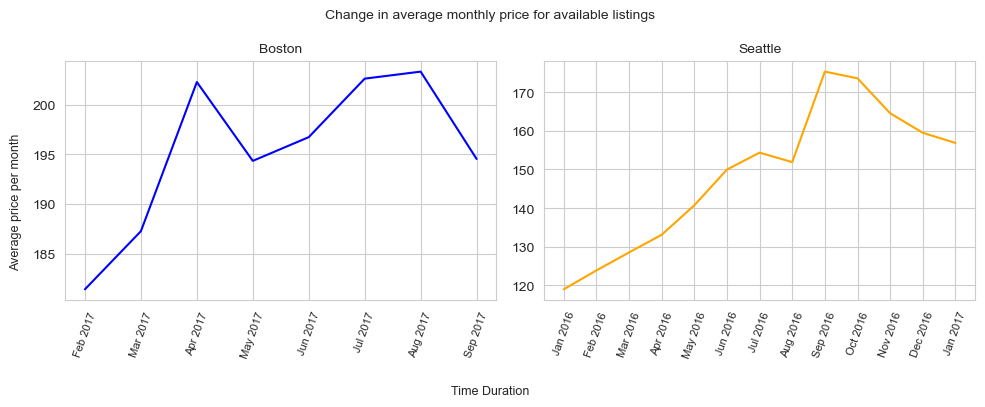

In [22]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 70

fig, axes = plt.subplots(1,2,figsize=(10,4))
fig.suptitle('Change in average monthly price for available listings',fontsize = fontsize_title)
fig.supxlabel('Time Duration',fontsize = fontsize_suplabel)
fig.supylabel('Average price per month',fontsize = fontsize_suplabel)

plot1 = sns.lineplot(x = "Time", y = "avg_monthly_price", data = temp_z[temp_z['city'] == 'Boston'],color='blue',ax=axes[0])
plot1.set_title('Boston',fontsize = 10)
plot1.set_xticklabels(labels = temp_z[temp_z['city'] == 'Boston']['Time'].unique(), rotation=rotation,fontsize = fontsize_ticks)
plot2 = sns.lineplot(x = "Time", y = "avg_monthly_price", data = temp_z[temp_z['city'] == 'Seattle'],color = "orange", ax=axes[1])
plot2.set_title('Seattle',fontsize = 10)
plot2.set_xticklabels(labels = temp_z[temp_z['city'] == 'Seattle']['Time'].unique(), rotation=rotation,fontsize = fontsize_ticks)

plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot1.set_ylabel(None)
plot2.set_ylabel(None)

fig.tight_layout()
plt.show()

### 1.1  Feb 2017 has the lowest avg. price while Apr,Jul and Aug 2017 are high for Boston
### 1.2  Jan 2016 has the lowest avg. price while Sep,Oct 2016 are high for Seattle

### Let's examine the price distribution within neighbourhoods of each city

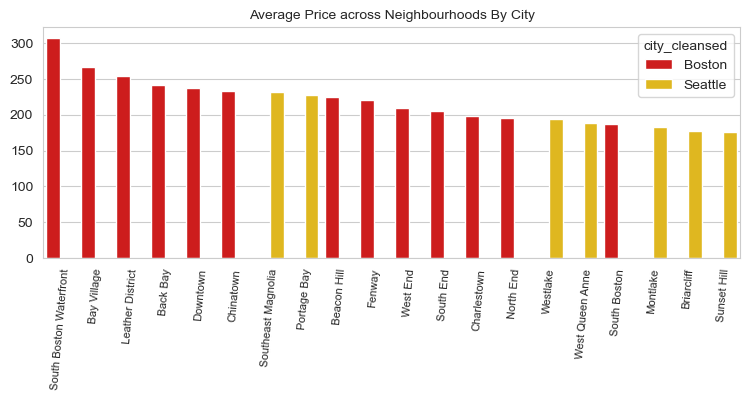

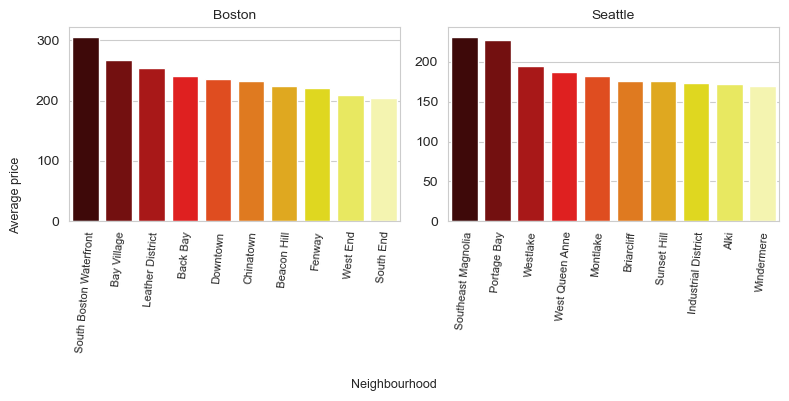

In [23]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 85

plt.figure(figsize = (9,3))

plot3 = sns.barplot(data=data_neighbourhood,x='neighbourhood_cleansed',y = 'average_price',hue = 'city_cleansed',palette = 'hot')
plot3.set_xticklabels(labels = neighbourhood,rotation=85,fontsize = fontsize_ticks)
plot3.set_title('Average Price across Neighbourhoods By City',fontsize = fontsize_title)
plot3.set_xlabel(None)
plot3.set_ylabel(None)

plt.show()

fig, axes = plt.subplots(1,2,figsize=(8,4))
fig.supxlabel('Neighbourhood',fontsize = fontsize_suplabel)
fig.supylabel('Average price',fontsize = fontsize_suplabel)
plot1 = sns.barplot(data=data_neighbourhood_boston,x='neighbourhood_cleansed',y = 'average_price',ax=axes[0],palette = 'hot')
plot1.set_xticklabels(labels = neighbourhood_boston,rotation=85,fontsize = fontsize_ticks)
plot1.set_title('Boston',fontsize = fontsize_title)

plot2 = sns.barplot(data=data_neighbourhood_seattle,x='neighbourhood_cleansed',y = 'average_price',ax=axes[1],palette = 'hot')
plot2.set_xticklabels(labels = neighbourhood_seattle,rotation=85,fontsize = fontsize_ticks)
plot2.set_title('Seattle',fontsize = fontsize_title)


plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot1.set_ylabel(None)
plot2.set_ylabel(None)

fig.tight_layout()




## Explanation

### Question 1 . "Does the listing pricing vary across cities and neighbourhoods within a city?"

### 1. Boston neighbourhoods are pricier than Seattle ones and Boston is pricier overall compared to Seattle
### 2. There is a price drop at the beginning of the year compared to the rest of the year in both sets, could be because of the holidays

## It would be more lucrative to own a listing in Boston as compared to Seattle

# Section 3 : Data Preparation

## 3. Explore & Assess

### Question 2 . "What kind of property types and room types are in high use based on reviews per month?"

#### 1. We will create 2 barplots,one each for Boston & Seattle's top 5 neighborhoods that show the total count of two year reviews against property & room type
#### 2. We will create 2 barplots,one each for Boston & Seattle's overall that show the total count of two year reviews against property & room type

### Looking at the differences in time periods across the seattle and Boston datasets and within the datasets themselves,let's focus on listings review dates falling with a 2 year period of the max date of the concatenated dataset

In [24]:
pd.DataFrame([['Boston',reviews_boston.date.max(),reviews_boston.date.min()],
             ['Seattle',reviews_seattle.date.max(),reviews_seattle.date.min()]],
             columns = ['City','Max_Review_Date','Min_Review_Date']).sort_values(['Max_Review_Date','Min_Review_Date'],
                                                                                 ascending=False)

,City,Max_Review_Date,Min_Review_Date
0,Boston,2016-09-06,2009-03-21
1,Seattle,2016-01-03,2009-06-07


In [25]:
### Setting the start and end dates for extracting 2 years reviews using max date of the concatenated reviews
duration = 24 #in months , we will extract all rows falling within this duration from the max date
reviews_max_date = reviews.max_date.max()
date_two_years_back = reviews_max_date - pd.DateOffset(months=duration) # finding the 2 years back date from the max date

In [26]:
print("Original reviews shape : ",reviews.shape)
reviews['has_past_two_years_data'] = np.where((reviews['min_date'] >= date_two_years_back) & \
                                              (reviews['max_date'] >= date_two_years_back),True,False) # filtering all reviews that are within the 2 year period
two_year_ids = reviews[reviews['has_past_two_years_data'] == True].listing_id.unique() # selecting those listing_ids

temp = reviews_df[reviews_df['listing_id'].isin(two_year_ids)] # filtering out those id reviews

print("two year reviews shape : ",temp.shape)

temp['has_two_years_data'] = np.where(temp['date']>=date_two_years_back,True,False) # checking if all entries are within two year period
print(temp['has_two_years_data'].value_counts())

temp.drop_duplicates(inplace=True) # dropping duplicates on all columns if any
print("two year reviews shape after dropping duplicates : ",temp.shape)

temp_x = temp.groupby('listing_id').agg(two_year_count = ('date','count')).reset_index() # grouping by listing id and aggregating on max review date by listing
reviews = pd.merge(reviews[['listing_id', 'max_date', 'min_date', 'total_review_count']],temp_x,on='listing_id') #merging with the original reviews dataframe to access the given columns
print("Final reviews shape : ",reviews.shape)
print(reviews.columns)

Original reviews shape :  (6020, 4)
two year reviews shape :  (68124, 6)
True    68124
Name: has_two_years_data, dtype: int64
two year reviews shape after dropping duplicates :  (68124, 7)
Final reviews shape :  (4441, 5)
Index(['listing_id', 'max_date', 'min_date', 'total_review_count',
       'two_year_count'],
      dtype='object')


In [27]:
data = pd.merge(listings,reviews[['listing_id','total_review_count','two_year_count']],left_on = 'id',right_on='listing_id') # merge reviews with listings to access the city,neighbourhood,property type and room type

In [28]:
# separate out listings for top priced Boston neighbourhoods, group by property_type, room_type and aggregate on the total sum of two year reviews count, sort by the sum descending and select top 5
boston_accomodation_df = data[data['neighbourhood_cleansed'].isin(neighbourhood_boston)].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5) 

# separate out listings for all of Boston and group by property_type, room_type and aggregate on the total sum of two year reviews count, sort by the sum descending and select top 5
overall_boston_accomodation_df = data[data['city_cleansed'] == 'Boston'].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)

# separate out listings for top priced Seattle neighbourhoods , group by property_type, room_type and aggregate on the total sum of two year reviews count, sort by the sum descending and select top 5
seattle_accomodation_df = data[data['neighbourhood_cleansed'].isin(neighbourhood_seattle)].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)

# separate out listings for all of Seattle and group by property_type, room_type and aggregate on the total sum of two year reviews count, sort by the sum descending and select top 5
overall_seattle_accomodation_df = data[data['city_cleansed'] == 'Seattle'].groupby(['property_type','room_type']).agg(total_count_two_year_reviews = ('two_year_count','sum')).sort_values(['total_count_two_year_reviews'],ascending=False).reset_index().head(5)

In [29]:
# Create a new column for all the above dataframe concatenating the property and room type that will help in visualization
boston_accomodation_df['property_room_type'] = boston_accomodation_df['property_type'] +'_with_'+ boston_accomodation_df['room_type']
overall_boston_accomodation_df['property_room_type'] = overall_boston_accomodation_df['property_type'] +'_with_'+ overall_boston_accomodation_df['room_type']
seattle_accomodation_df['property_room_type'] = seattle_accomodation_df['property_type'] +'_with_'+ seattle_accomodation_df['room_type']
overall_seattle_accomodation_df['property_room_type'] = overall_seattle_accomodation_df['property_type'] +'_with_'+ overall_seattle_accomodation_df['room_type']

### Let's check the null values in our dataframes

In [30]:
print("boston top priced : " , boston_accomodation_df.isna().sum())
print('-'*10)
print("boston overall : " ,overall_boston_accomodation_df.isna().sum())
print('-'*20)
print("seattle top priced : " , seattle_accomodation_df.isna().sum())
print('-'*10)
print("seattle overall : " ,overall_seattle_accomodation_df.isna().sum())

boston top priced :  property_type                   0
room_type                       0
total_count_two_year_reviews    0
property_room_type              0
dtype: int64
----------
boston overall :  property_type                   0
room_type                       0
total_count_two_year_reviews    0
property_room_type              0
dtype: int64
--------------------
seattle top priced :  property_type                   0
room_type                       0
total_count_two_year_reviews    0
property_room_type              0
dtype: int64
----------
seattle overall :  property_type                   0
room_type                       0
total_count_two_year_reviews    0
property_room_type              0
dtype: int64


### There are no null values

# Section 4 : Evaluation
## Visualize
### Question 2 . "What kind of property types and room types are in high use based on reviews per month?"

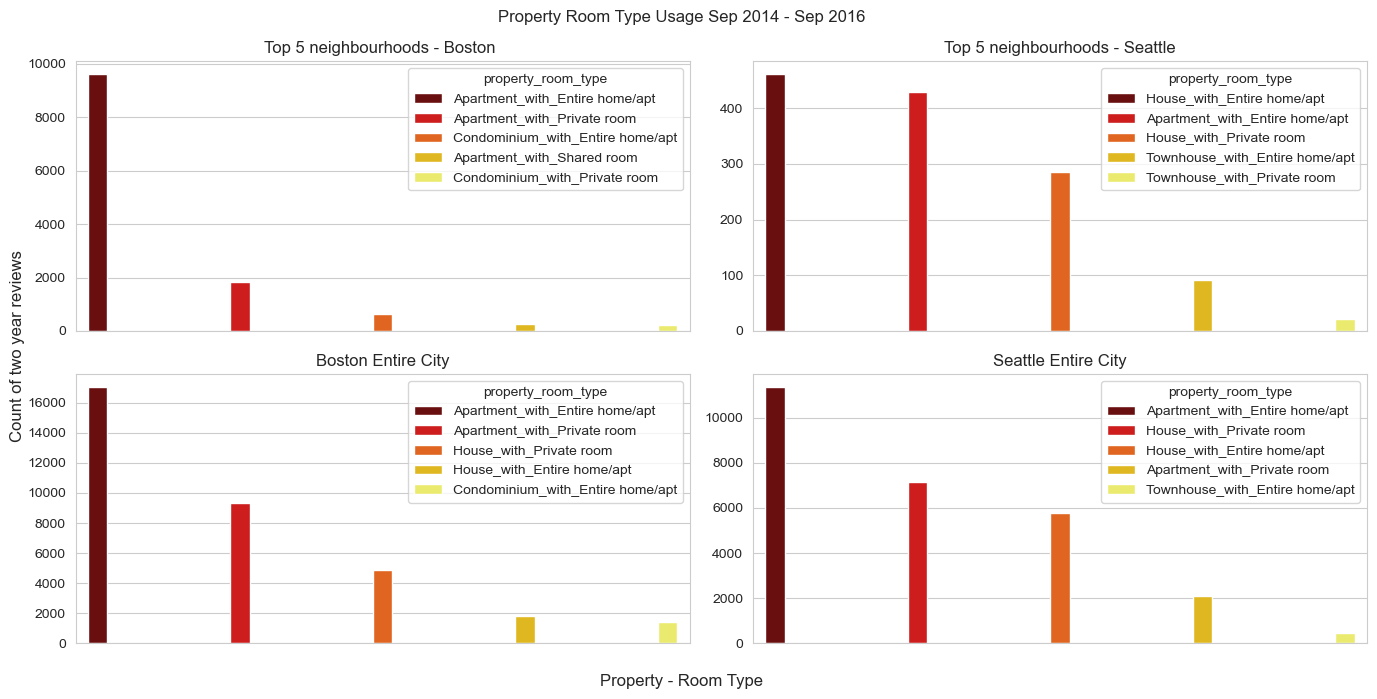

In [31]:
labels = []
fontsize_title = 12
fontsize_suplabel = 12
fontsize_ticks = 8
rotation = 85


fig, axes = plt.subplots(2, 2,figsize=(14,7))
fig.suptitle("Property Room Type Usage Sep 2014 - Sep 2016",fontsize=fontsize_title)
fig.supxlabel('Property - Room Type',fontsize=fontsize_suplabel)
fig.supylabel('Count of two year reviews',fontsize=fontsize_suplabel)

plot1 = sns.barplot(data=boston_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[0][0],palette = 'hot')
plot1.set_title('Top 5 neighbourhoods - Boston ' ,fontsize=fontsize_title)
plot1.set_xticklabels(labels= labels)
plot1.set_xlabel(None)
plot1.set_ylabel(None)

plot2 = sns.barplot(data=seattle_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[0][1],palette = 'hot')
plot2.set_title('Top 5 neighbourhoods - Seattle',fontsize=fontsize_title)
plot2.set_xticklabels(labels= labels)
plot2.set_xlabel(None)
plot2.set_ylabel(None)

plot3 = sns.barplot(data=overall_boston_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[1][0],palette = 'hot')
plot3.set_title('Boston Entire City' ,fontsize=fontsize_title)
plot3.set_xticklabels(labels= labels)
plot3.set_xlabel(None)
plot3.set_ylabel(None)

plot4 = sns.barplot(data=overall_seattle_accomodation_df,x='property_room_type',y = 'total_count_two_year_reviews',hue='property_room_type',ax=axes[1][1],palette = 'hot')
plot4.set_xticklabels(labels= labels)
plot4.set_title('Seattle Entire City',fontsize=fontsize_title)
plot4.set_xlabel(None)
plot4.set_ylabel(None)
fig.tight_layout()
plt.show()

## Explanation

### Question 2 . "What kind of property types and room types are in high use based on reviews per month?"

### 1. In the top priced boston neighbourhoods "entire apartment" is very popular
### 2. In the top priced seattle neighbourhoods "entire house" and "entire apartment" are very popular
### 3. The same pattern for each is observed in their respective overall plots as well, however the proportion of entire home/apartment in seattle is very small compared to the overall seattle data whereas for boston the proportion of entire apartment is high in the top priced neighbourhoods

##  Entire apartments are popular across both cities

# Section 3 : Data Preparation

## 3. Explore & Assess

### Question 3 . "What kind of amenities are associated with highly reviewed and popular listings?"

#### 1. We will create a scatterplot for boston where we will plot the total number of reviews against average reviews scores ratings , colored by the amenities associated with each listing
#### 2. We will create a scatterplot for seatlle where we will plot the total number of reviews against average reviews scores ratings , colored by the amenities associated with each listing

### Looking at the differences in time periods across the seattle and Boston datasets and within the datasets themselves,let's use listings with last_review_date falling within 2 years period from the max last_review_date of the Boston & Seattle concatendated data

In [32]:
listings['last_review'] = pd.to_datetime(listings['last_review'],errors='coerce') # Setting format of the last review date to datetime
max_review_date = listings['last_review'].max() # Setting format of the last review date to datetime
two_years_back =  max_review_date - pd.DateOffset(months=duration) # Setting format of the last review date to datetime

In [33]:
print("Max last review date Boston : " , listings[listings['city_cleansed'] == 'Boston'].last_review.max().date())
print("Man last review date Seattle : " , listings[listings['city_cleansed'] == 'Seattle'].last_review.max().date())

Max last review date Boston :  2016-09-06
Man last review date Seattle :  2016-01-03


In [34]:
listings['amenities'].head()  # the amenities column is a iterable of strings, it needs to be processed to make each string separate against a listing_id

0    {TV,"Wireless Internet",Kitchen,"Free Parking ...
1    {TV,Internet,"Wireless Internet","Air Conditio...
2    {TV,"Cable TV","Wireless Internet","Air Condit...
3    {TV,Internet,"Wireless Internet","Air Conditio...
4    {Internet,"Wireless Internet","Air Conditionin...
Name: amenities, dtype: object

In [35]:
data_boston = listings[(listings['city_cleansed'] == 'Boston') & (listings['last_review'] >= two_years_back) & (listings['last_review'] < max_review_date)] \
[['id','amenities','review_scores_rating','last_review','number_of_reviews']] # filtering out boston listings
temp_boston = data_boston.copy() # copying to a temporary dataframe
temp_boston['amenities_deconstructed'] = temp_boston['amenities'].apply(lambda x : re.sub('["{}\s]','',x).split(',')) # converting the iterable to a list so that we can use the explode function on it
print("Shape of temp_boston : " ,temp_boston.shape)

#Exploding the dataframe on amenities_deconstructed so that each listing will have all its amenities as a column
temp_boston = temp_boston.explode('amenities_deconstructed')[['id','review_scores_rating','number_of_reviews','amenities_deconstructed']].drop_duplicates() 
print("Shape of exploded dataframe : ", temp_boston.shape)

data_seattle = listings[(listings['city_cleansed'] == 'Seattle') & (listings['last_review'] >= two_years_back) & (listings['last_review'] < max_review_date)] \
      [['id','amenities','review_scores_rating','last_review','number_of_reviews']] # filtering out boston listings
temp_seattle = data_seattle.copy() # copying to a temporary dataframe
temp_seattle['amenities_deconstructed'] = temp_seattle['amenities'].apply(lambda x : re.sub('["{}\s]','',x).split(',')) # converting the iterable to a list so that we can use the explode function on it
print("Shape of temp_boston : " ,temp_seattle.shape)

#Exploding the dataframe on amenities_deconstructed so that each listing will have all its amenities as a column
temp_seattle = temp_seattle.explode('amenities_deconstructed')[['id','review_scores_rating','number_of_reviews','amenities_deconstructed']].drop_duplicates()
print("Shape of exploded dataframe : ", temp_seattle.shape)

Shape of temp_boston :  (2734, 6)
Shape of exploded dataframe :  (43967, 4)
Shape of temp_boston :  (3142, 6)
Shape of exploded dataframe :  (45482, 4)


In [36]:
print(temp_boston.amenities_deconstructed.unique())
print(temp_seattle.amenities_deconstructed.unique())

['TV' 'Internet' 'WirelessInternet' 'AirConditioning' 'Kitchen'
 'PetsAllowed' 'Petsliveonthisproperty' 'Dog(s)' 'Heating'
 'Family/KidFriendly' 'Washer' 'Dryer' 'SmokeDetector'
 'CarbonMonoxideDetector' 'FireExtinguisher' 'Essentials' 'Shampoo'
 'LockonBedroomDoor' 'Hangers' 'HairDryer' 'Iron' 'CableTV'
 'FreeParkingonPremises' 'FirstAidKit' 'SafetyCard'
 'translationmissing:en.hosting_amenity_49'
 'translationmissing:en.hosting_amenity_50' 'Gym' 'Breakfast'
 'IndoorFireplace' 'LaptopFriendlyWorkspace' 'Cat(s)' '24-HourCheck-in'
 'HotTub' 'Buzzer/WirelessIntercom' 'Otherpet(s)' 'Washer/Dryer'
 'SmokingAllowed' '' 'SuitableforEvents' 'WheelchairAccessible'
 'ElevatorinBuilding' 'Doorman' 'Pool' 'PaidParkingOffPremises'
 'FreeParkingonStreet']
['TV' 'CableTV' 'Internet' 'WirelessInternet' 'AirConditioning' 'Kitchen'
 'Heating' 'Family/KidFriendly' 'Washer' 'Dryer' 'FreeParkingonPremises'
 'Buzzer/WirelessIntercom' 'SmokeDetector' 'CarbonMonoxideDetector'
 'FirstAidKit' 'SafetyCard' 'Fir

### There are some unusual items in the amenities 'translationmissing:en.hosting_amenity_50 & 40' and ' '

## 3. Clean

In [37]:
## Removing these unusual entries
patterns = {'translationmissing:en.hosting_amenity_50':0,
            'translationmissing:en.hosting_amenity_49':0,'':0}
temp_boston['amenities_deconstructed'] = temp_boston['amenities_deconstructed'].apply(lambda c : patterns[c] if c in patterns.keys() else c)
temp_seattle['amenities_deconstructed'] = temp_seattle['amenities_deconstructed'].apply(lambda c : patterns[c] if c in patterns.keys() else c)

In [38]:
data_plot_boston = temp_boston.groupby('amenities_deconstructed').agg(listing_counts = ('id','count'),
                                   total_number_of_reviews = ('number_of_reviews','sum'), 
                                   avg_review_scores_rating = ('review_scores_rating','mean'))\
.sort_values('listing_counts',ascending=False).reset_index() # Grouping the data by amenities, aggregated by listing count for each,total number of reviews and avg review scores rating
data_plot_boston.drop_duplicates(inplace=True) # Dropping duplicates across all columns
print("boston amenities dataframe shape : " , data_plot_boston.shape)

data_plot_seattle = temp_seattle.groupby('amenities_deconstructed').agg(listing_counts = ('id','count'),
                                   total_number_of_reviews = ('number_of_reviews','sum'),
                                   avg_review_scores_rating = ('review_scores_rating','mean'))\
.sort_values('listing_counts',ascending=False).reset_index() # Grouping the data by amenities, aggregated by listing count for each,total number of reviews and avg review scores rating
data_plot_seattle.drop_duplicates(inplace=True)  # Dropping duplicates across all columns
print("seattle amenities dataframe shape : " , data_plot_seattle.shape)

boston amenities dataframe shape :  (44, 4)
seattle amenities dataframe shape :  (42, 4)


In [39]:
print("boston amenities : " ,data_plot_boston.isna().sum())
print('-'*20)
print("seattle amenities : " , data_plot_seattle.isna().sum())

boston amenities :  amenities_deconstructed     0
listing_counts              0
total_number_of_reviews     0
avg_review_scores_rating    0
dtype: int64
--------------------
seattle amenities :  amenities_deconstructed     0
listing_counts              0
total_number_of_reviews     0
avg_review_scores_rating    0
dtype: int64


### There are no null values

# Section 4 : Evaluation
## Visualize
### Question 3 . "What kind of amenities are associated with highly reviewed and popular listings ?"

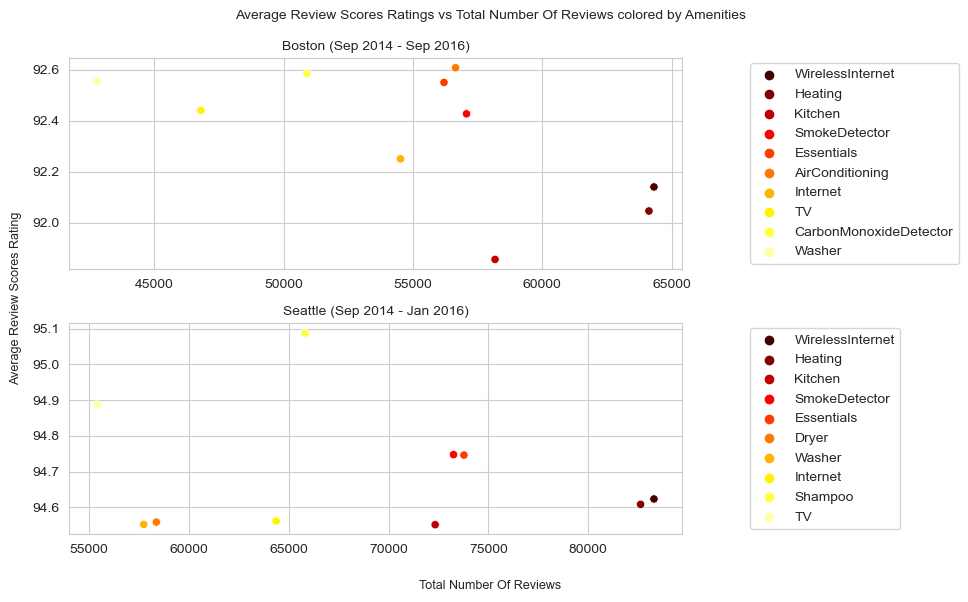

In [40]:
fontsize_title = 10
fontsize_suplabel = 9
fontsize_ticks = 8
rotation = 85

fig, axes = plt.subplots(2, 1,figsize=(10,6))
fig.suptitle('Average Review Scores Ratings vs Total Number Of Reviews colored by Amenities',fontsize=fontsize_title)
fig.supxlabel('Total Number Of Reviews',fontsize= fontsize_suplabel)
fig.supylabel('Average Review Scores Rating',fontsize= fontsize_suplabel)

plot1 = sns.scatterplot(data=data_plot_boston.head(10),x='total_number_of_reviews',y = 'avg_review_scores_rating',hue = 'amenities_deconstructed',palette='hot',ax = axes[0])
plot1.set_title('Boston (Sep 2014 - Sep 2016)' ,fontsize=fontsize_title)
plot1.legend(loc='center left', bbox_to_anchor=(1.1,.5), ncol=1)
plot1.set_xlabel(None)
plot1.set_ylabel(None)

plot2 = sns.scatterplot(data=data_plot_seattle.head(10),x='total_number_of_reviews',y = 'avg_review_scores_rating',hue = 'amenities_deconstructed',palette='hot',ax = axes[1])
plot2.set_title('Seattle (Sep 2014 - Jan 2016)' ,fontsize=fontsize_title)
plot2.legend(loc='center left', bbox_to_anchor=(1.1,.5), ncol=1,fontsize=10)
plot2.set_xlabel(None)
plot2.set_ylabel(None)

fig.tight_layout()
plt.show()

## Explanation

### Question 3 . "What kind of amenities are associated with highly reviewed and popular listings ?"

### 1. The first five amenities (WirelessInternet,Heating,Kitchen,SmokeDetector,Essentials) are common to both cities and are attached to a very large number of listings
### 2. The avg review scores rating also seem to be very good for these 5
### 3. The same pattern for each is observed in their respective overall plots as well, however the proportion of entire home/apartment in seattle is very small compared to the overall seattle data whereas for boston the proportion of entire apartment is high in the top priced neighbourhoods


## It would be safe to assume that the first five seem to be staple for a basic listing
## AirConditioning doesn't seem as important in Boston as well as shampoo, wonder why???

# Section 3 : Data Preparation

## 3. Explore & Assess

### Question 4. " How much influence do parameters like host response rate,host response time,host since and cancellation policy have on a listing's popularity and can these be used as recommendations to the hosts?"

#### 1. We will create a scatterplot for boston and seattle each where we will plot the host_response_rate against reviews scores ratings , colored by the host_response_time associated with each listing
#### 2. We will create a scatterplot for boston and seattle each where we will plot the host_response_rate against reviews scores ratings , colored by the host_since_year associated with each listing
#### 3. We will create a scatterplot for boston and seattle each where we will plot the host_response_rate against reviews scores ratings , colored by the cancellation_policy associated with each listing

In [41]:
listings['number_of_reviews'].describe()

count    7403.000000
mean       20.684047
std        36.733024
min         0.000000
25%         1.000000
50%         7.000000
75%        23.000000
max       474.000000
Name: number_of_reviews, dtype: float64

### The lowest number of reviews is 0 and maximim is 474, the mean number of reviews is 20, since we do have a listing with 400 reviews, let's set a threshold of 100 as we are looking at most popular listings (however we aren't accounting for positive or negative reviews)

### Let's focus on listings that have at least a 100 reviews

In [42]:
data = listings[listings['number_of_reviews']>=100]
[['id','review_scores_rating','host_response_time','host_acceptance_rate','host_listings_count',
'host_response_rate','host_since','cancellation_policy','city_cleansed','last_review','number_of_reviews']] # filtering out listings with more than 100 reviews
print("shape of the dataframe : " , data.shape, " and number of unique listings : ",data.id.nunique())
data = data[data['review_scores_rating'].notna()] # filtering out null reviews
print("shape after removing null reviews : ",data.shape,data.id.nunique())

shape of the dataframe :  (298, 78)  and number of unique listings :  298
shape after removing null reviews :  (298, 78) 298


In [43]:
print("Values in the cancellation policy : ",data['cancellation_policy'].unique())
print("Unique values for the host response rate : " ,data['host_response_rate'].unique())
print("Unique values for the host response time : " ,data['host_response_time'].unique())


Values in the cancellation policy :  ['flexible' 'moderate' 'strict']
Unique values for the host response rate :  ['100%' '85%' '92%' '99%' '93%' '90%' '94%' '84%' '96%' '97%' nan '70%'
 '86%' '75%' '95%' '71%']
Unique values for the host response time :  ['within a few hours' 'within an hour' 'within a day' nan]


In [44]:
print("Count of null values in the host since : " ,data['host_since'].isna().sum())

Count of null values in the host since :  0


In [45]:
print("Count of null values in the host response rate : ",data['host_response_rate'].isna().sum(),"\n Count of null values in the host response time : " , data['host_response_time'].isna().sum())

Count of null values in the host response rate :  3 
 Count of null values in the host response time :  3


### There are no null values in the number_of_reviews,cancellation policy,host_response_rate
### There are 3 null values in host_response_time and host_response_rate which is a very small value so we can convert them to -1 , we will assume that these two columns are ordinal and -1 is the least important value

## 3. Clean

In [46]:
data['host_response_rate'].head()

42     100%
50     100%
82     100%
115    100%
144    100%
Name: host_response_rate, dtype: object

In [47]:
# Remove the % from the host response rate and fill None values with -1
data['host_response_rate'] = data['host_response_rate'].apply(lambda x:int(str(x).replace('%','').strip()) if str(x)!='nan' else -1)

# Fill None values with -1
data['host_response_time'] = data['host_response_time'].fillna(-1)

# converting the host_since to datetime
data['host_since'] = pd.to_datetime(data['host_since'],errors='coerce')
# extracting the year from the host_since
data['host_since_year'] = data['host_since'].dt.year 

In [48]:
print("Range of number_of_reviews : ",data['number_of_reviews'].min(), '-',data['number_of_reviews'].max())

Range of number_of_reviews :  100 - 474


# Section 4 : Evaluation
## Visualize
### Question 4. " How much influence do parameters like host response rate,host response time,host since and cancellation policy have on a listing's popularity and can these be used as recommendations to the hosts?"

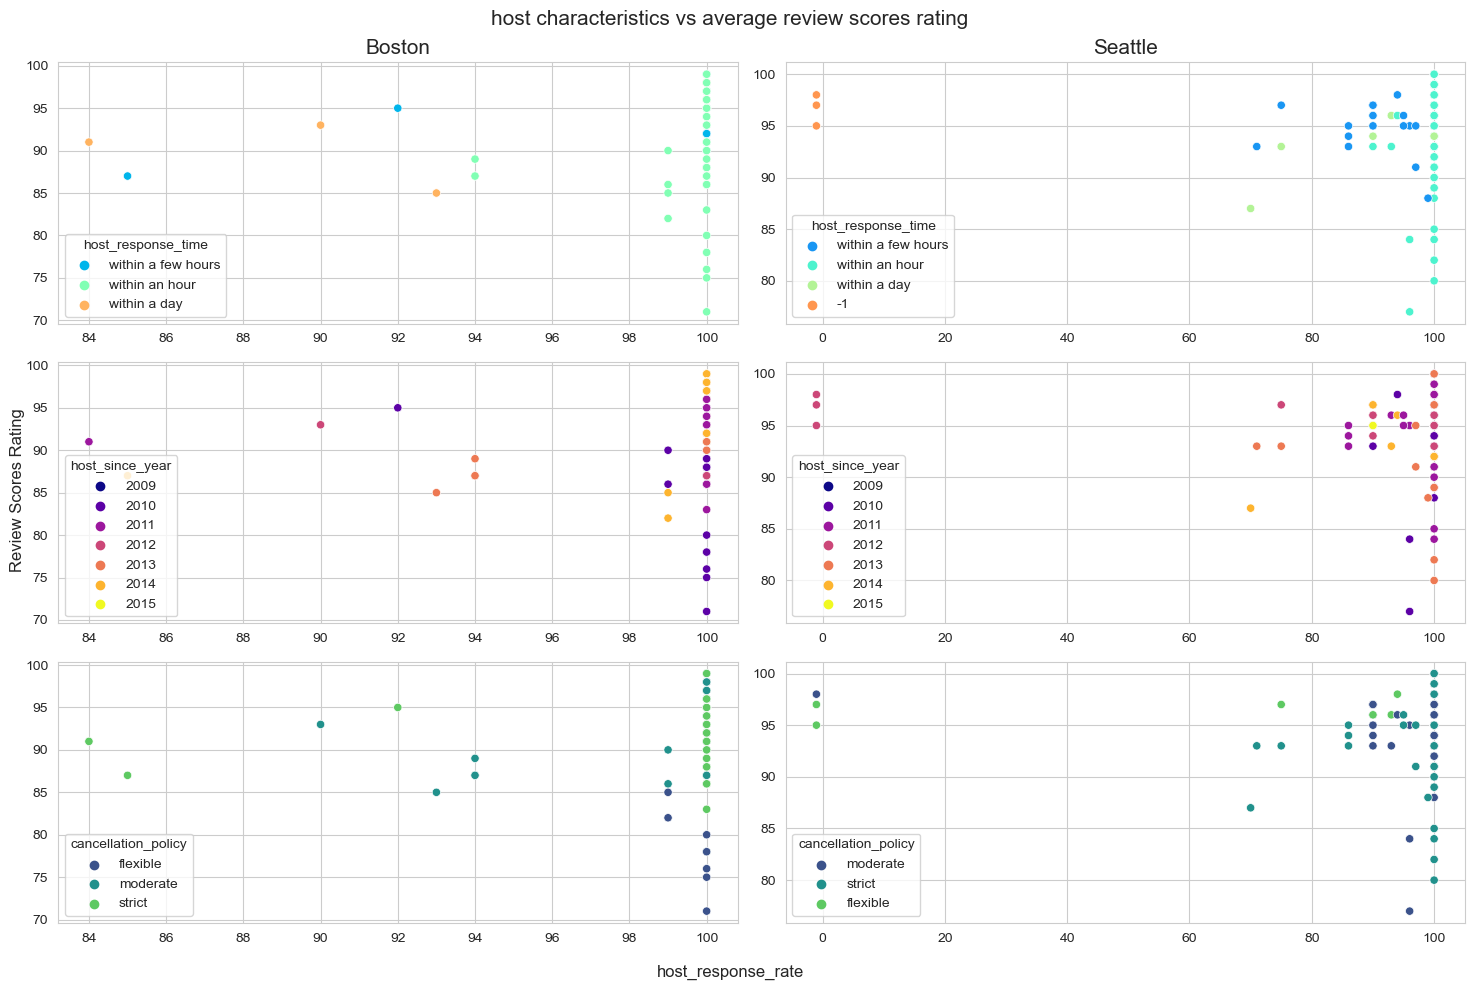

In [49]:
fontsize_title = 15
fontsize_suplabel = 12
fontsize_ticks = 9
rotation = 85

fig, axes = plt.subplots(3,2,figsize=(15,10))

fig.suptitle('host characteristics vs average review scores rating',fontsize = fontsize_title)
fig.supylabel('Review Scores Rating',fontsize = fontsize_suplabel)
fig.supxlabel('host_response_rate',fontsize = fontsize_suplabel)


plot1 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_response_time',ax=axes[0][0],palette='rainbow')
plot2 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_response_time',ax=axes[0][1],palette='rainbow')

plot3 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_since_year',ax=axes[1][0],palette='plasma')
plot4 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'host_since_year',ax=axes[1][1],palette='plasma')

plot5 = sns.scatterplot(data=data[data['city_cleansed'] == 'Boston'],x='host_response_rate',y = 'review_scores_rating',hue = 'cancellation_policy',ax=axes[2][0],palette='viridis')
plot6 = sns.scatterplot(data=data[data['city_cleansed'] == 'Seattle'],x='host_response_rate',y = 'review_scores_rating',hue = 'cancellation_policy',ax=axes[2][1],palette='viridis')

plot1.set_title('Boston',fontsize = fontsize_title)
plot2.set_title('Seattle',fontsize = fontsize_title)

plot1.set_ylabel(None)
plot2.set_ylabel(None)
plot3.set_ylabel(None)
plot4.set_ylabel(None)
plot5.set_ylabel(None)
plot6.set_ylabel(None)


plot1.set_xlabel(None)
plot2.set_xlabel(None)
plot3.set_xlabel(None)
plot4.set_xlabel(None)
plot5.set_xlabel(None)
plot6.set_xlabel(None)

fig.tight_layout()
plt.show()

## Explanation

### Question 4. " How much influence do parameters like host response rate,host response time,host since and cancellation policy have on a listing's popularity and can these be used as recommendations to the hosts?"

### 1. Upper right corner of the first two subplots shows that "within an hour" responses have higher scores for both seattle and boston and even "a few hours" is good enough for seattle
### 2. There doesn't seem to be any specific pattern for host since year, older as well as recent hosts seem to respond at higher rates , no pattern for ratings as well based on host since year
### 3. Hosts with "moderate" & "strict" policies seem to have higher review ratings for Boston while it's an equal mix for Seattle, no hosts with very strict policies are seen in the plots

## In order to be a good host, need to have a good response time typically within an hour or hew hours at least, have a relaxation on the cancellation policies as well, the hosts longevity on the field doesn't seem important int this data